In [176]:
import numpy as np
import pandas as pd
import os
import multiprocessing as mul
from multiprocessing import Process
import matplotlib.pyplot as plt
#import seaborn as sns
from scipy.optimize import minimize
from IPython.display import clear_output
from scipy.stats import chi2
from scipy.stats import norm

In [2]:
####
#### IMPORTING AND SPLITTING ICDATA $$$


path = "/media/darkwake/VIB2/Project-IceCube/icecube_10year_ps/events"
filenames = ["IC40_exp.csv", "IC59_exp.csv","IC79_exp.csv", "IC86_I_exp.csv", "IC86_II_exp.csv",
"IC86_III_exp.csv", "IC86_IV_exp.csv", "IC86_V_exp.csv", "IC86_VI_exp.csv", "IC86_VII_exp.csv"]
file = filenames[0]
f = open(os.path.join(path, file), 'r')
lines = f.readlines()
column=lines[0].split()
column.pop(0)
content = []
for file in filenames:
    f = open(os.path.join(path, file), 'r')
    lines = f.readlines()
    for line in lines[1:]:
        content.append(line.split())
    f.close()
icdata = pd.DataFrame(content, columns=column)
icdata['log10(E/GeV)'] = [float(i) for i in icdata['log10(E/GeV)']]


In [3]:


#IMPORTING MSPDATA
f = open("/media/darkwake/VIB2/Project-IceCube/allpsr.txt", 'r')
lines = f.readlines()

content=[]
column=lines.pop(0).split()
for line in lines[:]:
    content.append(line.split())
    #the INITAL DATABASE IS CLUTTERED SO WE REMOVE THE NULL COLUMNS AND OTHER CLUTTER
mspdata = pd.DataFrame(content).dropna().drop_duplicates()#.drop(range(0,6)).dropna().drop([2,6,8,10,11,13,14], axis=1)
f.close()
line = []
lines = []

mspdata.columns = column
column = []
content=[]
mspdata = mspdata.sort_values('DECJD')
mspdata.dropna(inplace=True)
mspdata = mspdata.reset_index()
mspdata = mspdata.drop(["index", "#"], axis=1)

In [4]:
mspdata

,NAME,Gl,Gb,RAJD,DECJD,P0,F0,DIST
0,J1852-0000,33.066,-0.277,283.16736,-0.00708,1.92066632921,0.520652642675,5.776
1,J1843-0000,32.013,1.768,280.86652,-0.01153,0.880334321703,1.13593208324,3.336
2,J1849-0001,32.638,0.527,282.2568,-0.02151,0.038522586319205,25.958797047369,*
3,J1852-0002g,32.985,-0.177,283.04,-0.03,0.2451,4.079967,5.591
4,J1850-0002g,32.738,0.305,282.5,-0.03,0.89336,1.11937,5.732
...,...,...,...,...,...,...,...,...
3238,J0152+0948,146.812,-50.221,28.0989,9.8028,2.74664729014,0.364080238329,2.477
3239,J1908+0949g,43.562,0.797,287.03,9.82,0.00905,110.497238,6.001
3240,J0550+09,197.055,-8.774,87.6,9.85,1.745,0.573066,1.804
3241,B1914+09,44.556,-1.019,289.134769,9.857216,0.2702544395645,3.700216735057,1.904


In [5]:
msra = [float(i) for i in mspdata['RAJD']]
msdec = [float(i) for i in mspdata['DECJD']]
icra = [float(i) for i in icdata['RA[deg]']]
icdec = [float(i) for i in icdata['Dec[deg]']]
icang = [float(i) for i in icdata['AngErr[deg]']]
global p, lg
p = len(msra)
lg = len(icra) // p + 1
#cut = 20
#cone = 3
#psrno = 0

In [6]:
def hvovec(lon1, lat1, lon2, lat2):

    #Convert decimal degrees to Radians:
    lon1 = np.deg2rad(lon1)
    lat1 = np.deg2rad(lat1)
    lon2 = np.deg2rad(lon2)
    lat2 = np.deg2rad(lat2)

    #Implementing Haversine Formula: 
    dlon = np.subtract(lon2, lon1)
    #dlat = np.subtract(lat2, lat1)

    a = np.add(np.multiply(np.sin(lat1), np.sin(lat2)), np.multiply(np.multiply(np.cos(lat1), np.cos(lat2)), np.cos(dlon)))

    return np.abs(np.rad2deg(np.arccos(a)))




def angfinder(b, cut):
    ang = []
    for a in range(lg):
        
        if a != lg - 1:
        #try:
            ilo = icra[a*p:a*p + p]
            ila = icdec[a*p:a*p + p]
            lo = msra[b] * np.ones(p)
            la = msdec[b] * np.ones(p)
            temp = hvovec(ilo, ila, lo, la)
            for tt in range(len(temp)):
                if temp[tt] > cut:
                    temp[tt] = -1
            ang.extend(temp)
        else:
        #except:
            ilo = icra[a*p:]
            ila = icdec[a*p:]
            ext = len(ilo)
            lo = msra[b] * np.ones(ext)
            la = msdec[b] * np.ones(ext)
            temp = hvovec(ilo, ila, lo, la)
            #ang.extend(hvovec(ilo, ila, lo, la))
            for tt in range(len(temp)):
                if temp[tt] > cut:
                    temp[tt] = -1
            ang.extend(temp)
        
    return ang


#aang = angfinder(psrno)

def S_ij(i, aang, cut):### $P_i[a] = \dfrac{ns[a]}{N} S[a] + \left(1 - \dfrac{ns[a]}{N}\right)B[a]$ if ns 
        
    if len(aang) < p*1.1:
        arr = []
        for j in range(0,len(icdata)):
            ang = aang[i][j]
            if ang != -1:
                if True and ang < cut:
                    sg = np.deg2rad(icang[j]) ** 2
                    ang = np.deg2rad(ang) ** 2
                    arr.append(np.exp(-1 * ang / (2 * sg)) / (2 * np.pi * sg))
        return arr
    else:
        arr = []
        for j in range(0,len(icdata)):
            ang = aang[j]
            if ang != -1:
                if True and ang < cut:
                    sg = np.deg2rad(icang[j]) ** 2
                    ang = np.deg2rad(ang) ** 2
                    arr.append(np.exp(-1 * ang / (2 * sg)) / (2 * np.pi * sg))
        return arr

#S = S_ij(psrno)

def nsang(aang, cut):
    Ns = []
    if len(aang) < p* 1.1:
        for i in aang:
            count = 0
            for j in i:
                if j != -1:
                    if j < cut:
                        count += 1
            Ns.append(count)
        Ns = np.array(Ns)
        return Ns
    else:
        count = 0
        for j in aang:
            if j != -1:
                if j < cut:
                    count += 1
        return count
#Ns = nsang(aang)


def bg(i, cone, Ns):
    #Calculating total no of neutrino events within delta +/- 6 of ith PULSAR (not neutrino)
    count = 0
    
    '''for j in icdec:
        if abs(msdec[i] - j) <= 6:
            count+=1 '''
    count = np.count_nonzero(np.abs(np.subtract(msdec[i],icdec))<cone)
    #calculating solid angle with lt deg conesxipy

#B = bg(psrno)

def Pr(x, Ns, S, B):
    nsN = x/Ns
    return np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))

def TS(i, x, S, B, Ns):
    if len(S) < p:
        return 2*np.sum(np.log(Pr(x,  Ns[i], S[i], B[i])/B[i]))
    else:
        return 2*np.sum(np.log(Pr(x,  Ns, S, B)/B))
#TS = lambda i, x: 

def TSmax(i, S, B, Ns):
    #returns the TSmax for i^th GRB
    #a = []
    #for j in range(1000):
        #a.append(TS(i,j))
         
    #init_guess = a.index(max(a))
    nll = lambda x: -TS(i,x, S, B, Ns)
    soln = minimize(nll, 3 ,bounds=((0,None),))#313, 314, 349, 370, 374, 378, 381, 394, 396, 397, 423, 434
    ns = float(soln.x)
    #print(f"Pulsar {i} done")
    return ns

def singpsr(psrno = 0, cut = 20, cone = 3):
    aang = angfinder(psrno, cut)
    Ns = nsang(aang, cut)
    S = S_ij(psrno, aang, cut)
    B = bg(psrno,cone, Ns)
    #TS(psrno, 0)
    maxns = TSmax(psrno, S, B, Ns)
    if maxns > 0:
        f = open(f"outputs/plots/{cut}cut/{cone}cone/problematic/Prob{cut}cut{cone}cone-TS({psrno}).txt", "w")
        f.write("nura, nudec, angerr\n")
        for i in range(len(aang)):
            if aang[i] != -1:
                f.write(str([icra[i], icdec[i], icang[i]]).replace('[', '').replace(']',''))
                f.write('\n')
        f.close()

        tms = TS(psrno, maxns, S, B, Ns)
        n = np.array(range(0, 1000))
        ts = [TS(psrno, x, S, B, Ns) for x in range(1000)]
        plt.figure(figsize=(8,6))
        plt.xscale('log')
        plt.plot(n, ts)
        plt.xlabel('x')
        plt.ylabel(f'TS({psrno}, x)')
        plt.title(f"{cut} cut {cone} cone TS({psrno})")
        plt.text(6, 3, s = f"TSmax = {tms} at ns = {maxns}")
        plt.savefig(f"outputs/plots/{cut}cut/{cone}cone/problematic/Prob{cut}cut{cone}cone-TS({psrno}).jpg")
        plt.show()
        plt.close()
        aang = None
        Ns = None
        S = None
        B = None
        tms = None
        ts = None
        n = None
    else:
        tms = TS(psrno, maxns, S, B, Ns)
        n = np.array(range(0, 1000))
        ts = [TS(psrno, x, S, B, Ns) for x in range(1000)]
        plt.figure(figsize=(8,6))
        plt.xscale('log')
        plt.plot(n, ts)
        plt.xlabel('x')
        plt.ylabel(f'TS({psrno}, x)')
        plt.title(f"{cut} cut {cone} cone TS({psrno})")
        plt.text(6, 3, s = f"TSmax = {tms} at ndef singpsr(psrno = 0, cut = 20, cone = 3")
        aang = angfinder(psrno, cut)
        Ns = nsang(aang, cut)
        S = S_ij(psrno, aang, cut)
        B = bg(psrno,cone, Ns)
        #TS(psrno, 0)
        maxns = TSmax(psrno, S, B, Ns)
        S = None
        B = None
        tms = None
        ts = None
        n = None
        
    #if showplot == True

for psrno in range(p):
    #psrno = np.random.randint(0, p)
    pfn = f"Prob20cut3cone-TS({psrno}).jpg"
    #/media/darkwake/VIB2/Project-IceCube/task4/outputs/plots/20cut/3cone/20cut3cone-TS(12).jpg
    fn = f"20cut3cone-TS({psrno}).jpg"
    if not(pfn in os.listdir("outputs/plots/20cut/3cone/")):
        if not(pfn in os.listdir("outputs/plots/20cut/3cone/problematic")):
            singpsr(psrno,  cut = 20, cone = 3)
    
    clear_output(wait=True)

In [7]:
def singpsr2(psrno = 0):
    cut = 20
    cone = 3
    aang = angfinder(psrno, cut)
    Ns = nsang(aang, cut)
    S = S_ij(psrno, aang, cut)
    B = bg(psrno,cone, Ns)
    #TS(psrno, 0)
    maxns = TSmax(psrno, S, B, Ns)
    return [maxns, np.sqrt(TS(psrno, maxns, S, B, Ns))]
tsmax = []
pool = mul.Pool(6, maxtasksperchild= 800)
op_async = pool.map_async(singpsr2, range(p))
tsmax = op_async.get()
op_async = []
pool = []
maxns = []
sqrtts = []
for i in tsmax:
    maxns.append(i[0])
    sqrtts.append(i[1])

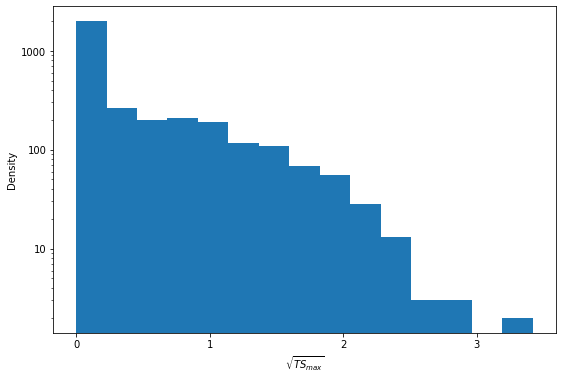

In [13]:

plt.figure(figsize=(9,6))
plt.yscale('log')
plt.yticks([1, 10, 100, 1000, 10000], [1, 10, 100, 1000, 10000])
#plt.
plt.xticks([0, 1, 2, 3, 4], [0, 1, 2, 3, 4])
plt.hist(sqrtts, 15)
plt.xlabel("$\sqrt{TS_{max}}$")
plt.ylabel("Density")
plt.savefig("outputs/sqrt(TSmax).jpg")
plt.show()

In [148]:
np.savetxt('tsmax.txt', sqrtts)

In [157]:
binnedsts, wsts = np.histogram(sqrtts, 15)

In [158]:
binnedsts

array([1989,  261,  199,  207,  189,  117,  108,   68,   56,   28,   13,
          3,    3,    0,    2])

In [159]:
binnedsts

array([1989,  261,  199,  207,  189,  117,  108,   68,   56,   28,   13,
          3,    3,    0,    2])

In [160]:
nerr = np.sqrt(binnedsts/np.sum(binnedsts))

In [161]:
wsts

array([0.        , 0.22799328, 0.45598656, 0.68397984, 0.91197311,
       1.13996639, 1.36795967, 1.59595295, 1.82394623, 2.05193951,
       2.27993278, 2.50792606, 2.73591934, 2.96391262, 3.1919059 ,
       3.41989918])

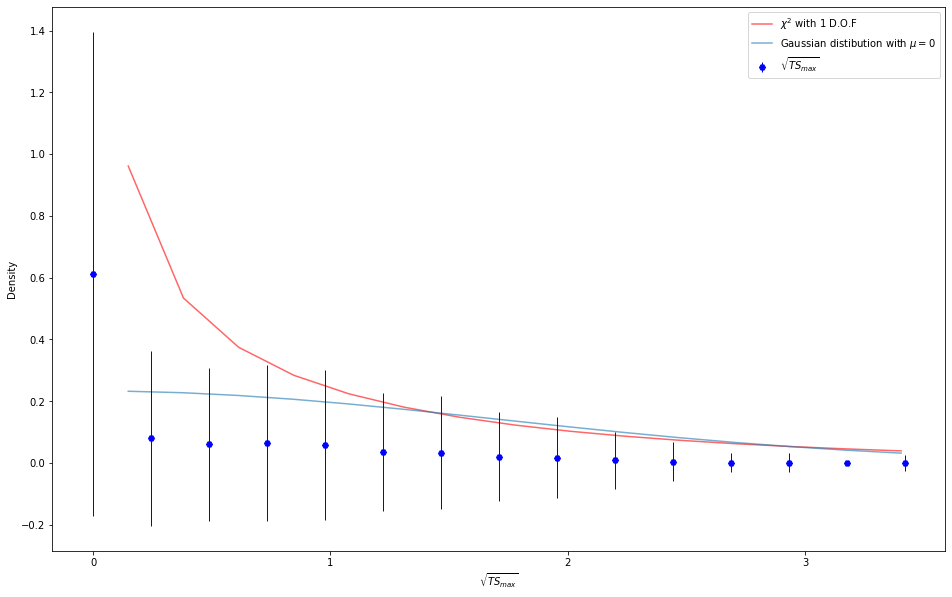

In [163]:
df = 1
x = np.linspace(chi2.ppf(0.3, df),chi2.ppf(0.935, df), 15)
plt.figure(figsize=(16,10))
#plt.yscale('log')
#plt.yticks([1, 10, 100, 1000, 10000], [1, 10, 100, 1000, 10000])

plt.plot(x, chi2.pdf(x, df),'r-', alpha=0.6, label=f'$\chi^2$ with {df} D.O.F')
plt.plot(x, norm.pdf(x, 0, np.mean(wsts)),'-', alpha=0.6, label=f'Gaussian distibution with $\mu = 0$')
plt.xticks([0, 1, 2, 3, 4], [0, 1, 2, 3, 4])
plt.errorbar(np.linspace(0, max(wsts), 15), binnedsts/np.sum(binnedsts), nerr,  aa = True, barsabove = True, fmt='Hb',ecolor='blue', elinewidth=1, label='$\sqrt{TS_{max}}$')
plt.xlabel("$\sqrt{TS_{max}}$")
plt.ylabel("Density")
plt.legend()
plt.savefig("outputs/sqrt(TSmax)errbar.jpg")
plt.show()

In [184]:
sqbin, sqwt = np.histogram(np.square(sqrtts), 15)

In [186]:
sqwt

array([ 0.        ,  0.77971402,  1.55942805,  2.33914207,  3.1188561 ,
        3.89857012,  4.67828415,  5.45799817,  6.2377122 ,  7.01742622,
        7.79714025,  8.57685427,  9.3565683 , 10.13628232, 10.91599635,
       11.69571037])

In [187]:
len(sqwt)

16

In [201]:
sqerr = np.sqrt(sqbin/np.sum(sqbin))

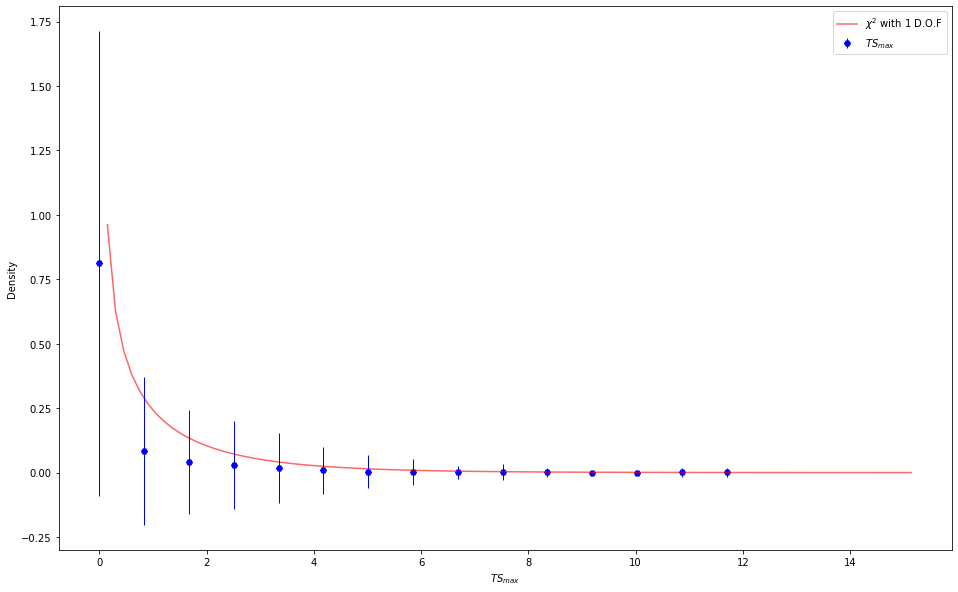

In [202]:
df = 1
x = np.linspace(chi2.ppf(0.3, df),chi2.ppf(0.9999, df), 100)
plt.figure(figsize=(16,10))
#plt.yscale('log')
#plt.yticks([1, 10, 100, 1000, 10000], [1, 10, 100, 1000, 10000])

plt.plot(x, chi2.pdf(x, df),'r-', alpha=0.6, label=f'$\chi^2$ with {df} D.O.F')
#plt.plot(x, norm.pdf(x, 0, np.mean(sqwt)),'-', alpha=0.6, label=f'Gaussian distibution with $\mu = 0$')
#plt.xticks([0, 1, 2, 3, 4], [0, 1, 2, 3, 4])
plt.errorbar(np.linspace(0, max(sqwt), 15), sqbin/np.sum(sqbin), sqerr,  aa = True, barsabove = True, fmt='Hb',ecolor='blue', elinewidth=1, label='${TS_{max}}$')
plt.xlabel("${TS_{max}}$")
plt.ylabel("Density")
plt.legend()
plt.savefig("outputs/sqrt(TSmax)errbar2.jpg")
plt.show()